# Modelling and Evaluation Notebook

## Objectives

The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew

## Inputs

- inputs/datasets/cherry-leaves/test
- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation
- image shape embeddings

## Outputs

- Images distribution plot in train, validation, and test set.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model optimization using Kerastuner.
- Model evaluation on pickle file.
- Prediction on the random image file.

---

### Import packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set Working Directory


In [3]:
cwd= os.getcwd()
cwd

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [4]:
os.chdir('/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves'

---

### Set input directories

In [6]:
data_dir = 'inputs/datasets/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

print('Train path: ', train_path,'\n' 'Validation path: ', val_path,'\n' 'Test path: ', test_path)

Train path:  inputs/datasets/cherry-leaves/train 
Validation path:  inputs/datasets/cherry-leaves/validation 
Test path:  inputs/datasets/cherry-leaves/test


### Set output directory


In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels


In [8]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['powdery_mildew', 'healthy']


### Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

---

## Number of images in train, test and validation dataset

---

Set: train, Label: powdery_mildew, Number of images: 1479
Set: train, Label: healthy, Number of images: 1466
Set: validation, Label: powdery_mildew, Number of images: 205
Set: validation, Label: healthy, Number of images: 215
Set: test, Label: powdery_mildew, Number of images: 420
Set: test, Label: healthy, Number of images: 423




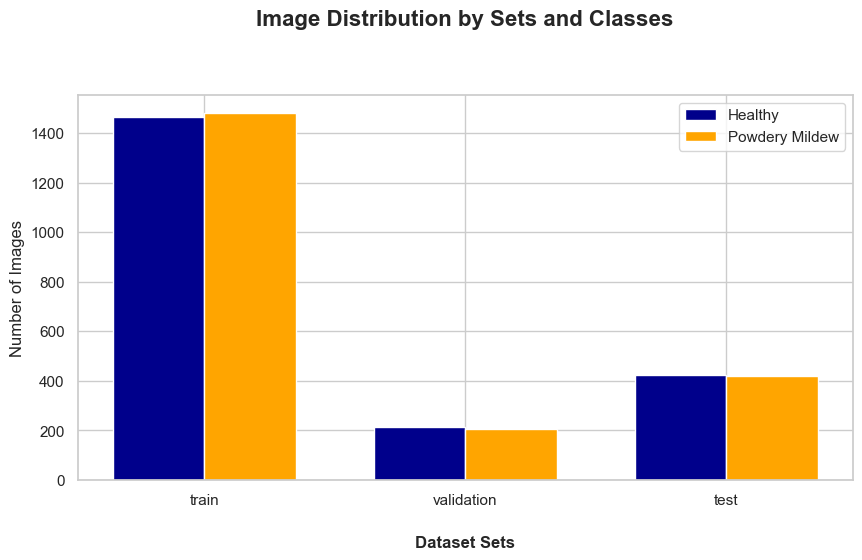

In [10]:
data_freq = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        path = os.path.join(data_dir, folder, label)
        data_freq.append(pd.DataFrame({'set': folder, 'label': label, 'count': [len(os.listdir(path))] }))
        print(f"Set: {folder}, Label: {label}, Number of images: {len(os.listdir(path))}")

# Concatenate the DataFrames
merged_data = pd.concat(data_freq)

# Create variables for plotting
index = np.arange(len(merged_data['set'].unique()))
sets = merged_data['set'].unique()
healthy_counts = merged_data[merged_data['label'] == 'healthy']['count']
mildew_counts = merged_data[merged_data['label'] == 'powdery_mildew']['count']

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
bar_width = 0.35

plt.bar(index, healthy_counts, bar_width, label='Healthy', color='darkblue')
plt.bar([i + bar_width for i in index], mildew_counts, bar_width, label='Powdery Mildew', color='orange')

plt.xlabel('Dataset Sets', labelpad=20, fontweight = 'bold')
plt.ylabel('Number of Images')
print('\n')
plt.title('Image Distribution by Sets and Classes', pad=50, fontsize=16, fontweight='bold')
plt.xticks([i + bar_width / 2 for i in index], sets) 
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.legend()
plt.legend()
plt.show()


---

## Image data augmentation


---

#### ImageDataGenerator

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Laad images from directory

In [12]:
def load_images(img_path, target_size=(100, 100), num_images=5):
    if os.path.isdir(img_path):
        img_filenames = os.listdir(img_path)[:num_images]
        img_paths = [os.path.join(img_path, img_filename) for img_filename in img_filenames]
        img_arrays = [image.img_to_array(image.load_img(path, target_size=target_size)) for path in img_paths]
        img_arrays = np.array(img_arrays)
        return img_arrays

#### Initialize ImageDataGenerator

In [14]:
def create_data_generator(directory, target_size=(100, 100), batch_size=32, class_mode='binary', shuffle=True):
    data_generator = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=(0.5, 1.5),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        brightness_range=[0.5, 1.5],
        channel_shift_range=0.5,
        rotation_range=30,
        shear_range=0.5,
    )

    data_set = data_generator.flow_from_directory(
        directory,
        target_size=target_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle,
    )

    return data_set


In [15]:
train_set = create_data_generator(train_path, shuffle=True)

Found 2945 images belonging to 2 classes.


#### Augment validation image dataset

In [16]:
validation_set = create_data_generator(val_path, shuffle=False)


Found 420 images belonging to 2 classes.


#### Augment test image dataset

In [17]:
test_set = create_data_generator(test_path, shuffle=False)


Found 843 images belonging to 2 classes.


### Plot augmented training images

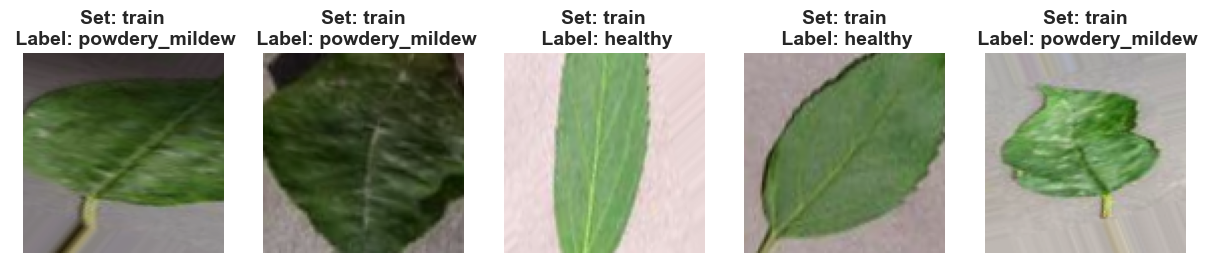

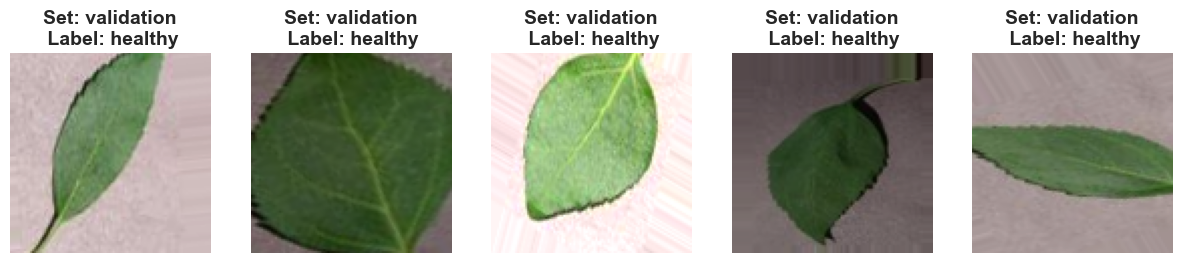

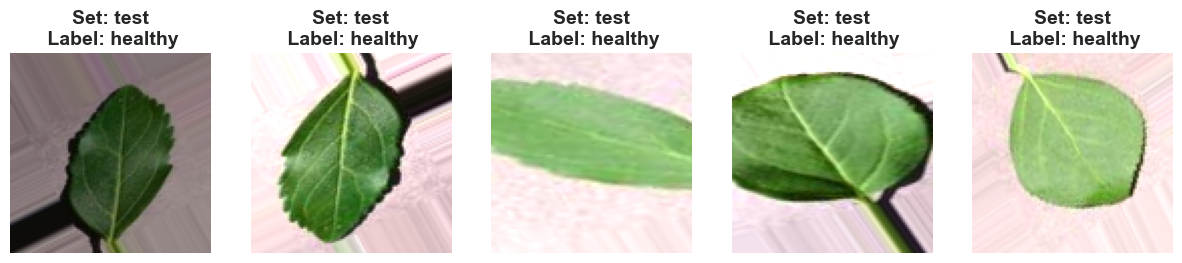

In [18]:
import matplotlib.pyplot as plt

def plot_images(data_generator, set_name):
    # Get a batch of images and labels
    images, labels = next(data_generator)

    # Map numerical labels to class names
    class_names = list(data_generator.class_indices.keys())

    # Get the class name for each label in the batch
    batch_class_names = [class_names[int(l)] for l in labels]

    # Plot the images
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(images))):  # Plot at most 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Set: {set_name}\n Label: {batch_class_names[i]}", fontsize=14, fontweight='bold')
        plt.axis('off')
    plt.show()

# Assuming you have the data generators defined (train_set, validation_set, test_set)
# You can use the function to plot images from each set
plot_images(train_set, set_name='train')
plot_images(validation_set, set_name='validation')
plot_images(test_set, set_name='test')


#### Save class_indices


In [18]:

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation and training

---

### Import model packages

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [20]:
%pip install keras-tuner


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Model

In [22]:
def simple_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
                  
    return model

#### Model summary

In [23]:
simple_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0

 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 457985 (1.75 MB)
Trainable params: 457985 (1.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Early stopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#### Fit Model for training

In [25]:
model = simple_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // train_set.batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )



Epoch 1/25
92/92 [==============================] - 11s 117ms/step - loss: 0.3702 - accuracy: 0.8125 - val_loss: 0.2073 - val_accuracy: 0.9143
Epoch 2/25
92/92 [==============================] - 11s 117ms/step - loss: 0.1761 - accuracy: 0.9355 - val_loss: 0.1025 - val_accuracy: 0.9714
Epoch 3/25
92/92 [==============================] - 10s 109ms/step - loss: 0.1377 - accuracy: 0.9523 - val_loss: 0.0987 - val_accuracy: 0.9667
Epoch 4/25
92/92 [==============================] - 10s 113ms/step - loss: 0.0984 - accuracy: 0.9674 - val_loss: 0.0873 - val_accuracy: 0.9643
Epoch 5/25
92/92 [==============================] - 10s 108ms/step - loss: 0.0852 - accuracy: 0.9767 - val_loss: 0.0849 - val_accuracy: 0.9762
Epoch 6/25
92/92 [==============================] - 10s 113ms/step - loss: 0.0750 - accuracy: 0.9804 - val_loss: 0.0595 - val_accuracy: 0.9738
Epoch 7/25
92/92 [==============================] - 11s 120ms/step - loss: 0.0780 - accuracy: 0.9773 - val_loss: 0.0551 - val_accuracy: 0.9810

#### Save model

In [28]:
model.save(f"outputs/v1/simple_model.keras")

#### Model learning curve

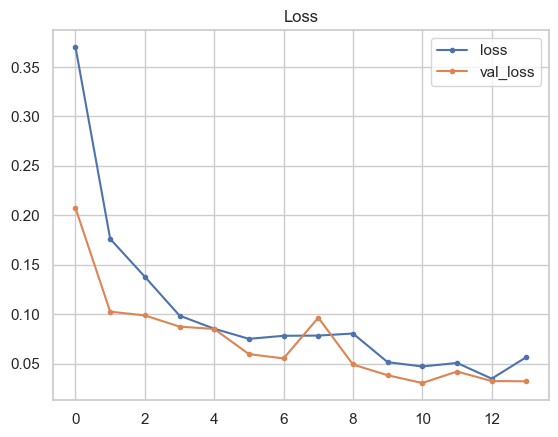

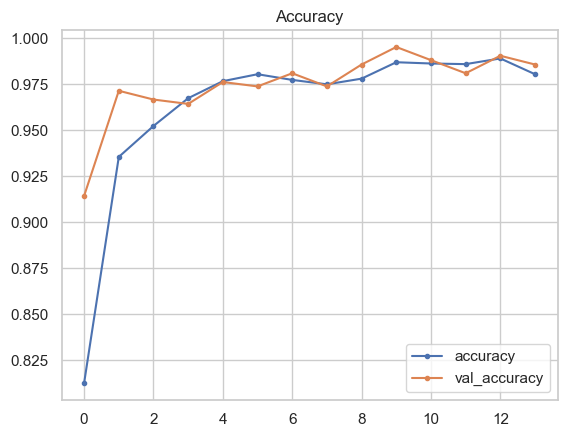

In [29]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

### Model Optimizing

---

#### A Hyperparameter Tuning Approach with Keras Tuner

In [99]:

def tune_model(hp):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(100, 100, 3), activation='relu'))
    pool_size = hp.Choice('pool_size', values=[1, 2])
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu')) 
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


### Hyperparameter Tuning with Early Stopping using Keras Tuner

In [100]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# RandomSearch Tuner
tuner = RandomSearch(
    tune_model,
    objective='val_accuracy',
    max_trials=15,
    directory='keras_tuner_dir',
    project_name='tune_model',
    metrics=['accuracy'],
    overwrite=True
)


# Search for the best hyperparameters with early stopping
tuner.search(train_set, epochs=25, validation_data=validation_set, callbacks=[early_stopping])

# Get the best trial from the tuner
best_trial = tuner.oracle.get_best_trials(1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_trial.hyperparameters)
best_model.summary()

# Save the best model's weights
best_model.save_weights('keras_tuner_dir/tune_model/best_model_weights')



Trial 9 Complete [00h 01m 51s]
val_accuracy: 0.9904761910438538

Best val_accuracy So Far: 0.9952380657196045
Total elapsed time: 00h 40m 22s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 

#### Display model summary

In [101]:
# Get the best trial from the combined tuner
best_trial = tuner.oracle.get_best_trials(1)[0]

# Display information about the best trial
hyperparameters = best_trial.hyperparameters.values
print(f"Best Trial ID: '\n'{best_trial.trial_id}, '\n'Hyperparameters: '\n'{hyperparameters}")


Best Trial ID: '
'02, '
'Hyperparameters: '
'{'pool_size': 2, 'dropout_rate': 0.1}


#### Save model

In [153]:
best_model.save('outputs/v1/optimized_model.keras')

---

## Model Performace

---

#### Load model best weights and fit model for training

In [103]:
# ModelCheckpoint callback to save best weights during training
checkpoint_callback = ModelCheckpoint(
    'keras_tuner_dir/tune_model/best_model_weights',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


# Train the best model and store the history
history = best_model.fit(train_set, epochs=30, validation_data=validation_set, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.7980 
Epoch 1: val_accuracy improved from -inf to 0.66429, saving model to keras_tuner_dir/tune_model/best_model_weights
93/93 [==============================] - 1018s 11s/step - loss: 0.4358 - accuracy: 0.7980 - val_loss: 0.8605 - val_accuracy: 0.6643
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9019
Epoch 2: val_accuracy improved from 0.66429 to 0.91905, saving model to keras_tuner_dir/tune_model/best_model_weights
93/93 [==============================] - 8s 90ms/step - loss: 0.2465 - accuracy: 0.9019 - val_loss: 0.1796 - val_accuracy: 0.9190
Epoch 3/30
93/93 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9430
Epoch 3: val_accuracy improved from 0.91905 to 0.95952, saving model to keras_tuner_dir/tune_model/best_model_weights
93/93 [==============================] - 8s 90ms/step - loss: 0.1685 - accuracy: 0.9430 - val_loss: 0.11

#### Learning Curves for Cherry Leaves Classification

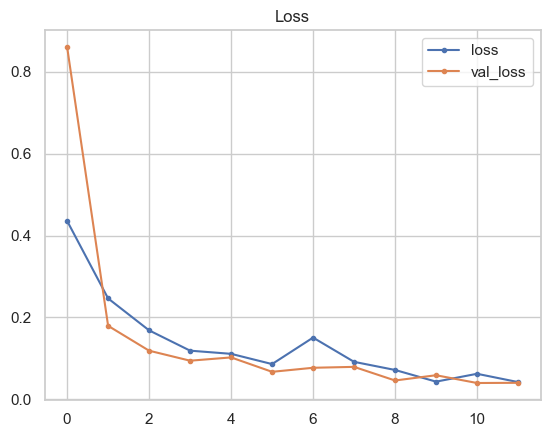

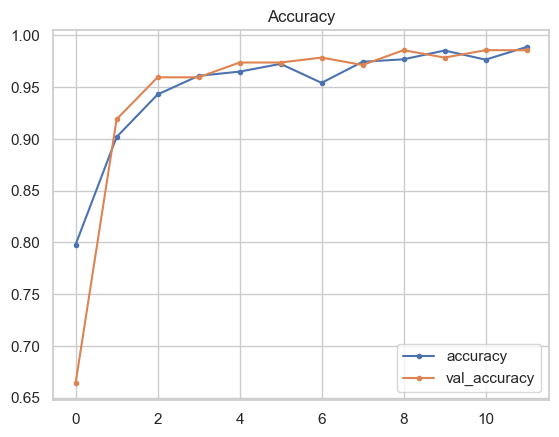

In [104]:

# Extract loss and accuracy from the training history
losses = pd.DataFrame(history.history)

# Plot training and validation losses
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig('keras_tuner_dir/tune_model/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot training and validation accuracy
print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig('keras_tuner_dir/tune_model/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

#### Model Evaluation

In [151]:
# Evaluate the model on the validation set
evaluation_results = best_model.evaluate(test_set)

# Print the evaluation results (e.g., loss and accuracy)
print("Evaluation Results:", evaluation_results)
loss = evaluation_results[0]
accuracy = evaluation_results[1]

# Print the evaluation results (loss and accuracy)
print("Validation Loss:", round(loss, 3))
print("Validation Accuracy:", round(accuracy, 3))

27/27 [==============================] - 1s 51ms/step - loss: 0.0424 - accuracy: 0.9905
Evaluation Results: [0.0424407459795475, 0.990510106086731]
Validation Loss: 0.042
Validation Accuracy: 0.991


In [30]:
from keras.models import load_model

#  Load model 
model = load_model('outputs/v1/optimized_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict the labels for the test set
predictions = model.predict(test_set)
y_true = test_set.classes
y_pred = (predictions > 0.5).astype(int).flatten()

# Create a dictionary to store evaluation results
evaluation = {
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
}


27/27 [==============================] - 2s 66ms/step - loss: 0.0352 - accuracy: 0.9929
Test Loss: 0.0352, Test Accuracy: 0.9929
27/27 [==============================] - 2s 60ms/step


#### Model Evaluation on pickle file

In [168]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

### Prediction on the unseen image file

#### Load random image file

Image shape: (100, 100), Label: healthy


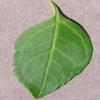

In [179]:
from tensorflow.keras.preprocessing import image

pointer = 11
label = labels[1]  # select 1 for healthy or 0 for powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Label: {label}')
pil_image

#### Convert image to array


In [180]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


#### Predict class probabilities

In [181]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 18ms/step
0.9950295849703252
healthy


---

### Conclution

- The final evaluation on the test set shows a low loss of 0.0355, indicating that the model makes accurate predictions with minimal errors.
- The test accuracy is very high at 99.05%, suggesting that the model successfully learned and generalized well to unseen data.